**Правила:**
* Отчеты принимаются до **23:59 19 ноября**. Вы должны залить ваш ноутбук в github дать на него ссылку в следующей [форме](https://forms.gle/88d9CfaJN5gPV4bB8).
* Работоспособность будет проверяться через [colab](https://colab.research.google.com) (можете сразу давать ссылку на него). Если ноутбук не будет исполняться (падать по ошибке) то все, что будет написано после ошибки не будет учитываться при формировании оценки. Для самопроверки, выполните аналог restart kernel and run all cells в colab
* Вы должны включить код, с помощью которого вы общались с API вконтакте, но для экономии времени, заранее предусмотреть возможность загрузки уже собранных данных (например, как это было реализовано в ноутбуках по кластеризации через `wget` и dropbox или raw данными в github)

**Пожелания:**
* Выбирайте для анализа небольшие сообщества (до 5к), желательно чтобы вы сами в них состояли - это ускорит вычисления и упростит интерпретацию
* Отнеситесь к этой работе как к исследованию - больше графиков и комментариев!
* Красивые визуализации лучше делать через gephi!

</br>

# Загрузка данных (2 балла)

Изучите следующие материалы
* [Знакомство с API](https://vk.com/dev/first_guide)
* [Туториал](https://nbviewer.jupyter.org/github/allatambov/Py-programming-3/blob/master/15-06/lect-vk-api.ipynb) по выгрузке данных с помощью VKAPI
* Про метод execute - [туть](https://vk.com/dev/execute) и [туть](http://www.cyberforum.ru/python-web/thread1730446.html)

Выберите сообщество и загрузите
* Идентификаторы всех [участников сообщества](https://vk.com/dev/groups.getMembers)
* [Списки друзей](https://vk.com/dev/friends.get) участников и их признаки (пол, возраст, университет и все, что посчитаете нужным - нам потом группировать по этим атрибутам)
* [Пересечение](https://vk.com/dev/friends.getMutual) между списками друзей

Таким образом вы должны получить замкнутую группу аккаунтов с их друзьями и связями между ними.

Далее - соберите их этого граф в networkX и сохраните в graphml или gml формате

**Замечания:**
* Вконтакте может ограничить вам скорость запросов, поэтому иногда имеет смысл ставить небольшую паузу (`time.sleep(1)`) между запросами и сохранять предварительные результаты
* Код выгрузки может быть написан как с помощью модуля `vk` так и просто с помощью requests
* Некоторые пользователи могли сделать свой аккаунт приватным, что может вызвать ошибку в методе `getMutual`. Чтобы этого избежать придется проверять каждого на приватность с помощью `users.get` и аттрибута `is_closed`


### Загрузка данных ###
Построим граф на основе сообщества **Подслушано СУНЦ МГУ**. </br>
Следующий код позволяет загрузить информацию о 300 участниках сообщества и ихдрузьях. Ограничения появляются в связи с ошибкой **Rate limit reached**. </br>
Я загрузила информацию для 4 разных блоков, в итоге, если удалить все закрытые, забаненные и удаленные профили, получилось **845** участников.

Сначала пару слов о СУНЦ-е. Это школа-интернат, в которой есть только 10 и 11 класс. Причем все классы разделены на 2 потока: химбио (химия, биология, экология) и физмат (физика, математика, информатика).

In [77]:
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
import vk, requests, json, time
fields = "sex, age, bdate, city, country, education, universities, is_closed"

token = 'tokentokentoken'
session = vk.Session(access_token = token)              # открыть сессию для работы
api = vk.API(session,  v = '5.62')                      # подключиться к API
group_id = 'free_aesc'
"""

In [36]:
"""
# идентификаторы всех участников сообщества
# всего в группе 2866 подписчиков. Добавляем только открытые аккаунты среди 300 пользователей
count  = 0    # comment out if you run again 
items  = []   # comment out if you run again 
us_get = []   # comment out if you run again 
print("Get community members:")
current_group_members = api.groups.getMembers(group_id=group_id, v = "5.92", offset = 500, count = 300)
for id_ in tqdm_notebook(current_group_members['items']):
    temp_usget = api.users.get(user_ids = id_ , v = "5.126", fields = fields)[0]
    if 'is_closed' in temp_usget.keys() and not temp_usget['is_closed'] and not 'deactivated' in temp_usget.keys():
        items.append(id_)
        us_get.append(temp_usget)
        count += 1
    time.sleep(0.5)
group_members = {'count' : count,
                 'items' : items}
print("Got:   ", count, 'users')
"""

Get community members:



Got:    845 users


In [37]:
"""
# cписок друзей и их атрибуты
group_members_friends = []  # comment out if you run again 
group_members_owners  = []  # comment out if you run again 
for temp in tqdm_notebook(range(628,group_members['count'])):
    friend = api.friends.get(user_id = us_get[temp]['id'], fields = fields, v = '5.126')
    group_members_friends.append(friend)
    group_members_owners.append(us_get[temp]['id'])
    time.sleep(0.5)  
"""    

Получаем список попарных пересечений друзей. Ниже представлено 2 варианта: с помощью vk и перебором (вторым способом у меня получилось быстрее + не выскакивает ограничение на количество использованных операций).

In [ ]:
"""
# общие друзья участников
group_members_common_friends       = []
group_members_common_friends_owner = []
for temp1 in tqdm_notebook(range(group_members['count'])):
    for temp2 in range(temp1 + 1, group_members['count']):
        common_friends = api.friends.getMutual(source_uid = us_get[temp1]['id'], target_uid = us_get[temp2]['id'])
        group_members_common_friends.append(common_friends)
        group_members_common_friends_owner.append([us_get[temp1]['id'], us_get[temp2]['id']])
        time.sleep(0.5)
"""

In [43]:
"""
# Собираем id всех друзей для участников группы
friends_id_dict = []
for friend in group_members_friends:
    friends_id = []
    for temp in range(friend['count']):
        friends_id.append(friend['items'][temp]['id'])
    friends_id_dict.append(friends_id)

# function
group_members_common_friends = {}
for temp1 in tqdm_notebook(range(len(friends_id_dict))):
    temp1_id = us_get[temp1]['id']
    for temp2 in range(temp1 + 1, len(friends_id_dict)):
        temp2_id = us_get[temp2]['id']
        common_friends = []
        for id_ in friends_id_dict[temp2]:
            if id_ in friends_id_dict[temp1]:
                common_friends.append(id_)
        if common_friends:
            group_members_common_friends[(temp1_id,temp2_id)] = common_friends
group_members_common_friends
"""

### Преобразование в граф ###
В граф будем включать участников сообщества и их общих друзей.

In [49]:
"""
# множество всех идентификаторов, которые будут включены в граф
all_id = group_members['items']
for list_id in group_members_common_friends.values():
    all_id += list_id 
set_id = set(all_id)
"""

In [75]:
"""
import networkx as nx
g = nx.Graph()
g.graph['title'] = 'aesc_free group network'
"""

In [76]:
"""
# Добавляем вершины и ребра
for temp1 in tqdm_notebook(range(len(group_members_friends))):
    group_member_id = group_members_owners[temp1]
    g.add_node(group_member_id)
    friends_couples = []
    friend = group_members_friends[temp1]
    for temp2 in range(friend['count']):
        if friend['items'][temp2]['id'] in set_id:
            friends_couples.append(  (group_member_id, friend['items'][temp2]['id'])  )
    g.add_edges_from(friends_couples)
"""

In [77]:
"""
# Расставляем признаки вершин
key_words = ['sex', 'bdate', 'university', 'faculty', 'graduation']#, \
spetial_key_words = ['country', 'city']

for group_member in tqdm_notebook(us_get):
    id_ = group_member['id']
    for kw in key_words:
        if kw in group_member.keys():
            g.nodes[id_][kw] = group_member[kw]
    for kw in spetial_key_words:
        if kw in group_member.keys():
            g.nodes[id_][kw] = group_member[kw]['id']

for friends in group_members_friends:
    for friend in friends['items']:
        id_ = friend['id']
        if id_ in set_id:
            for kw in key_words:
                if kw in friend.keys():
                    g.nodes[id_][kw] = friend[kw]
            for kw in spetial_key_words:
                if kw in friend.keys():
                    g.nodes[id_][kw] = friend[kw]['id']
                
nx.write_gml(g, 'aesc_free.gml')
""""

</br>

# Визуализация (1 балл)

Для визуализации полученного графа в **Gephi** используется алгоритм **ForceAtlas 2**: </br>

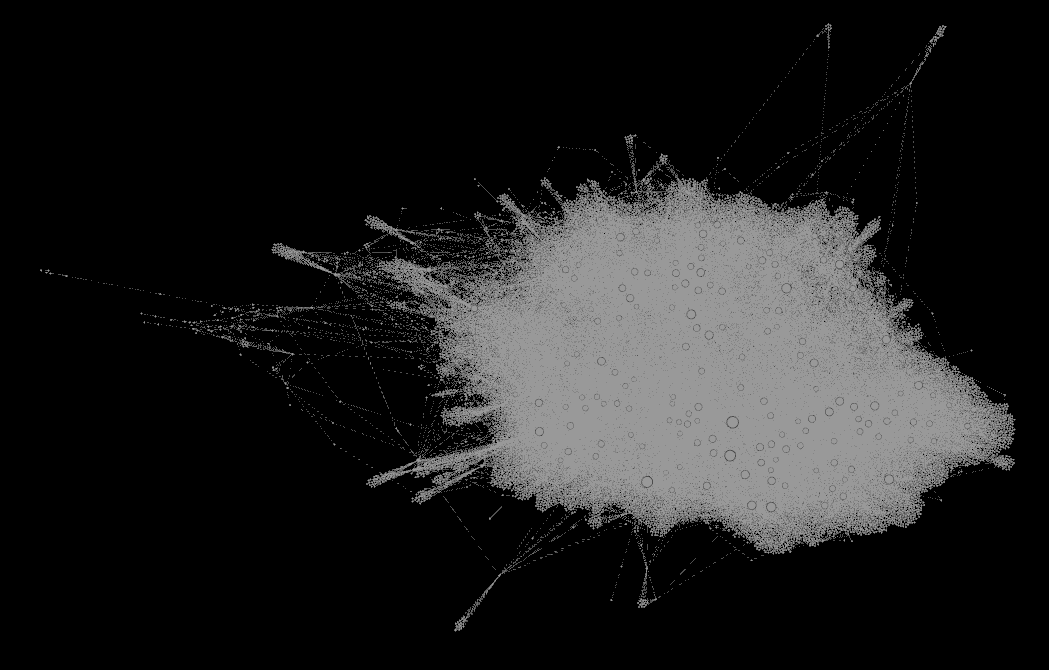

Граф представляет собой большой сгусток с островками на перефериии (их хорошо видно слева). Можно предположить, что это одноклассники или общие знакомые текущего поколения "сунцов" (во-первых, на картинках ниже будет видно, что вершины, находящиеся в правой части графа, соответствуют выпускникам, во-вторых, обособленность островков может быть следствием дистанционного обучения - школьники меньше знакомятся общаются друг с другом).

Посмотрим в какие вузы поступают выпускники "сунца": </br>

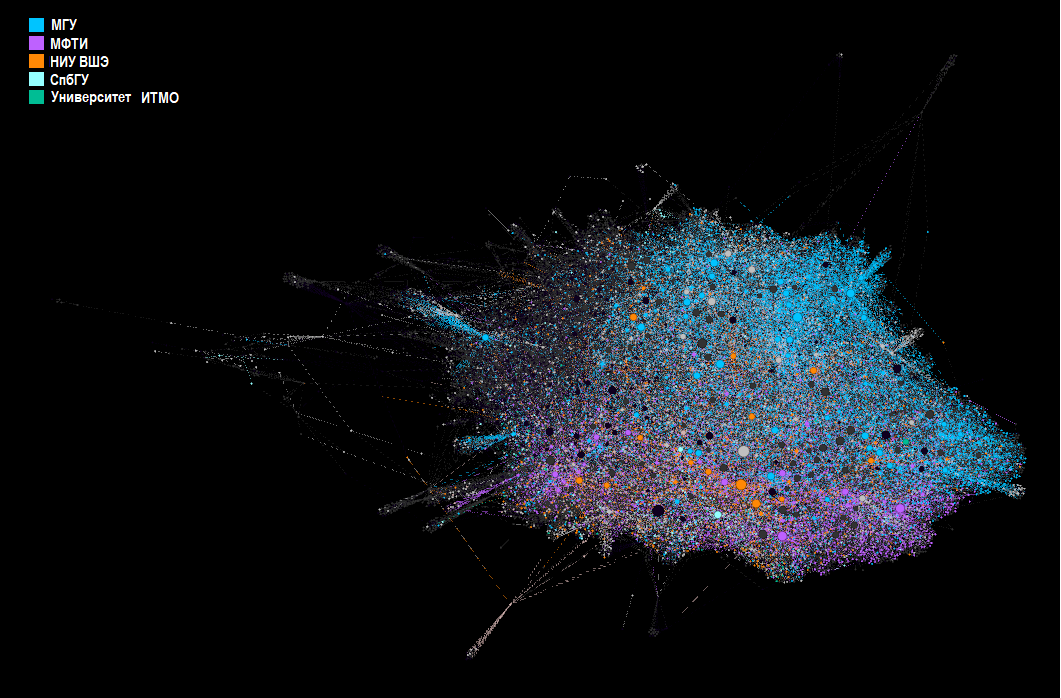

Очевидно, что большинство продолжает учебу в МГУ, МФТИ и НИУ ВШЭ. Заметим, что островки, о которых говорилось ранне почти полностью темно-серого цвета, что говорит о том, что информация о высшем образовании отсутствует, т.е. эти островки состоят из школьников.

Аналогично можно посмотреть на распределение по факультетам для всего графа: </br>

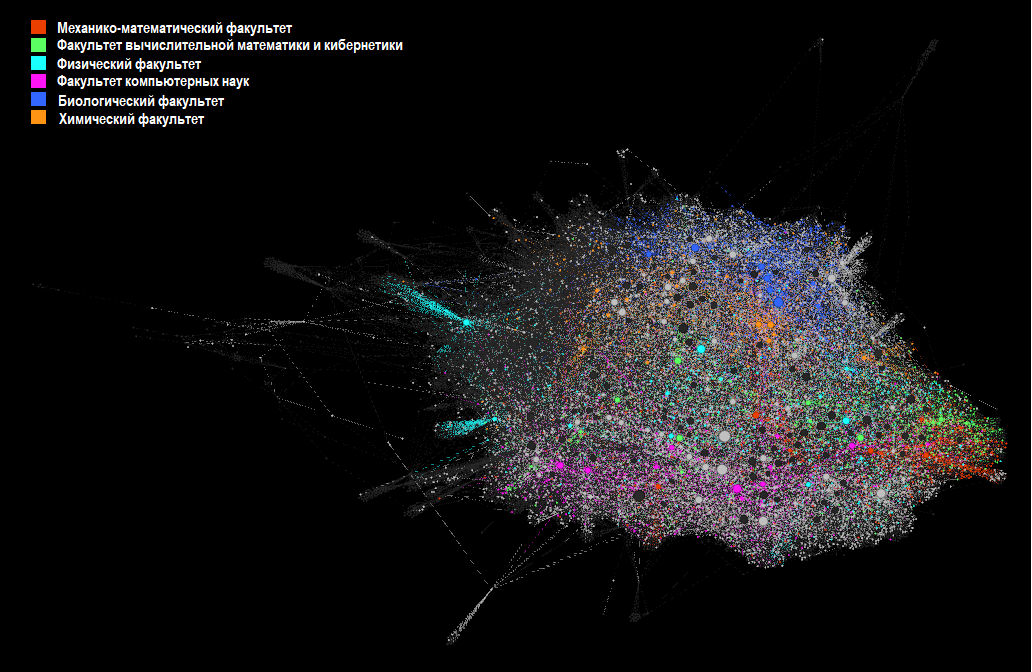

И на расперделение по факультетам для двух самых популярных вузов. Для МГУ:</br>

Можно сразу визуально разделить выпускников на 2 группы:
* Химбио поток
* Физмат поток

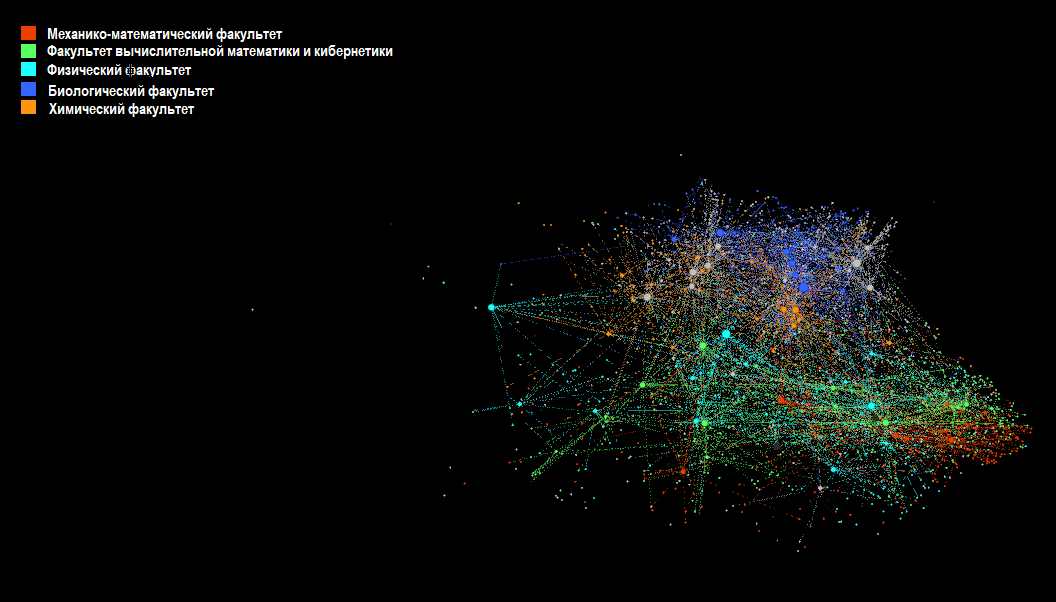

Для МФТИ:</br>

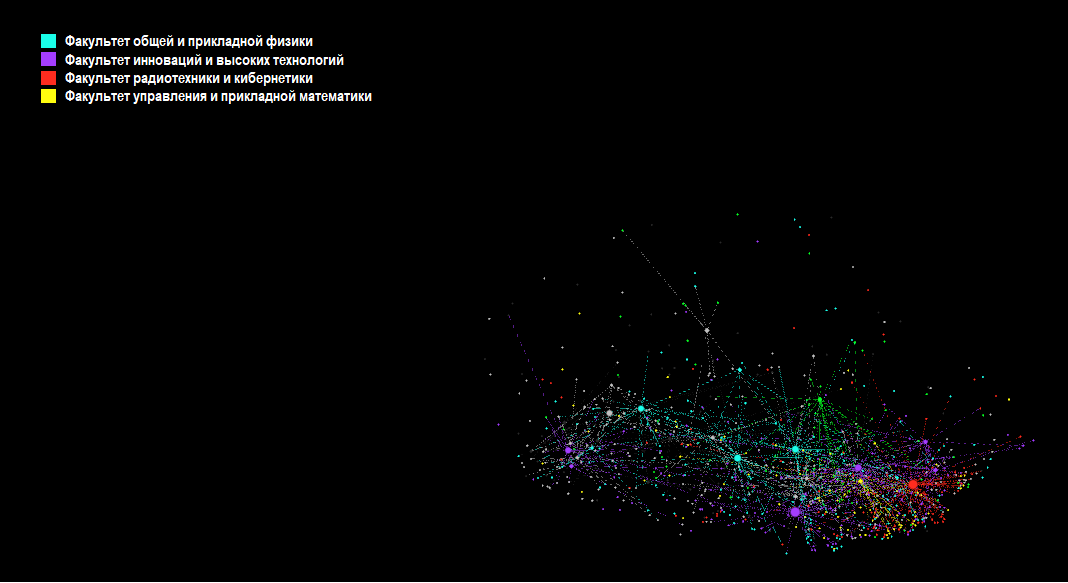

</br>

# Центральности вершин (2 балла)

Возможно, перед тем как пойти дальше, стоит немного почитстить граф - с помощью [kcore](https://www.google.com/search?client=firefox-b-d&q=networkx+kcore)

* Найдите наиболее влиятельные вершины с точки зрения degree, closeness и betweenness centrality
* Выделите их на картинке в gephi

In [2]:
import networkx as nx
from networkx.algorithms.core import k_core
import numpy as np

In [166]:
g = nx.read_gml('aesc_free.gml')

In [9]:
kcore_g = k_core(g, k = 10)

Исходный граф:

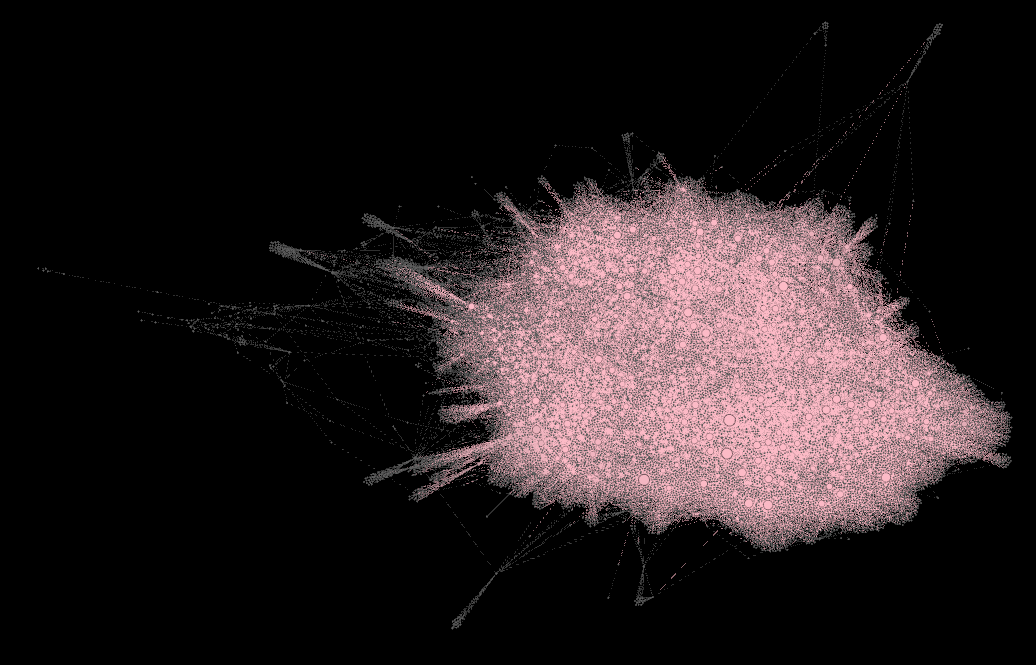

kcore:

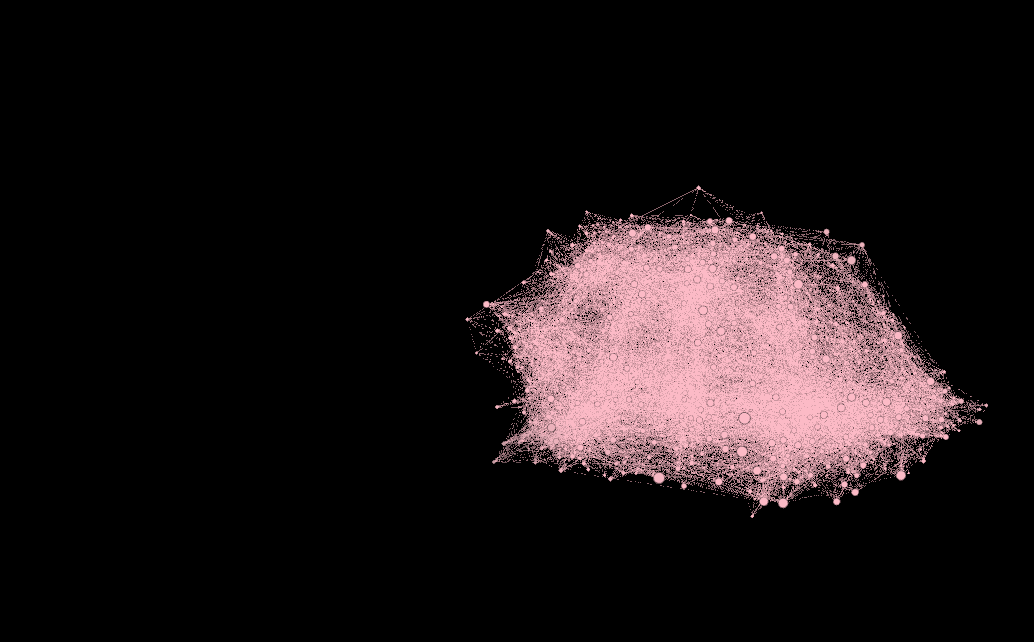

In [6]:
def get_main_id(g_dict, main_count = 10):
    mean_values = np.sort(np.array(list(g_dict.values())))[-main_count:]
    return {x: y for x, y in filter(lambda x: g_dict[x[0]] in mean_values, g_dict.items())} 

### degree centrality ###

In [7]:
nodes = nx.degree_centrality(g)

In [8]:
res = get_main_id(nodes, main_count = 10)
res

{'142073657': 0.020483624838596077,
 '154610867': 0.02118793285596901,
 '207313851': 0.02412254959502289,
 '224304589': 0.020483624838596077,
 '225749253': 0.022537856555933794,
 '143787333': 0.030813475760065732,
 '273411381': 0.024005164925460735,
 '210523445': 0.028817936377509096,
 '156291087': 0.028289705364479396,
 '140787532': 0.0233008569080878,
 '207198114': 0.02065970184293931}

Изобразим найденный точки на графе. В основном, это студенты и школьники, которые ведут активную жизнь в ВКонтакте.

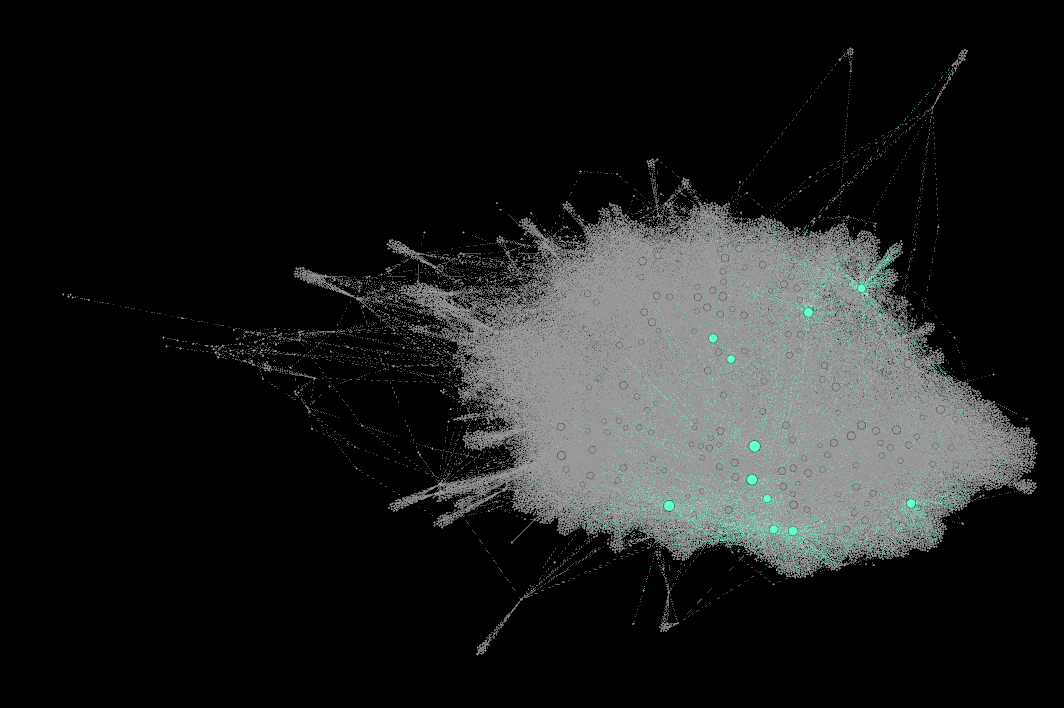

### closeness centrality ###

In [13]:
nodes = nx.closeness_centrality(kcore_g)

In [14]:
res = get_main_id(nodes, main_count = 10)
res

{'593203': 0.5270713699753896,
 '438016103': 0.50293542074364,
 '126087663': 0.48915112295393987,
 '142073657': 0.4927147239263804,
 '264499309': 0.5083069620253164,
 '158862755': 0.4884074496389206,
 '255852114': 0.4900839054157132,
 '573548': 0.5025420414548298,
 '207313851': 0.49423076923076925,
 '225749253': 0.5135891286970423}

Изобразим найденный точки на графе. Это:
- преподаватели 
- биологи и химики, у которых физику вели преподавили с физмат потока 
- люди, которые "одинаково дружат" как с химбио, так и с физмат потоком
</br></br>

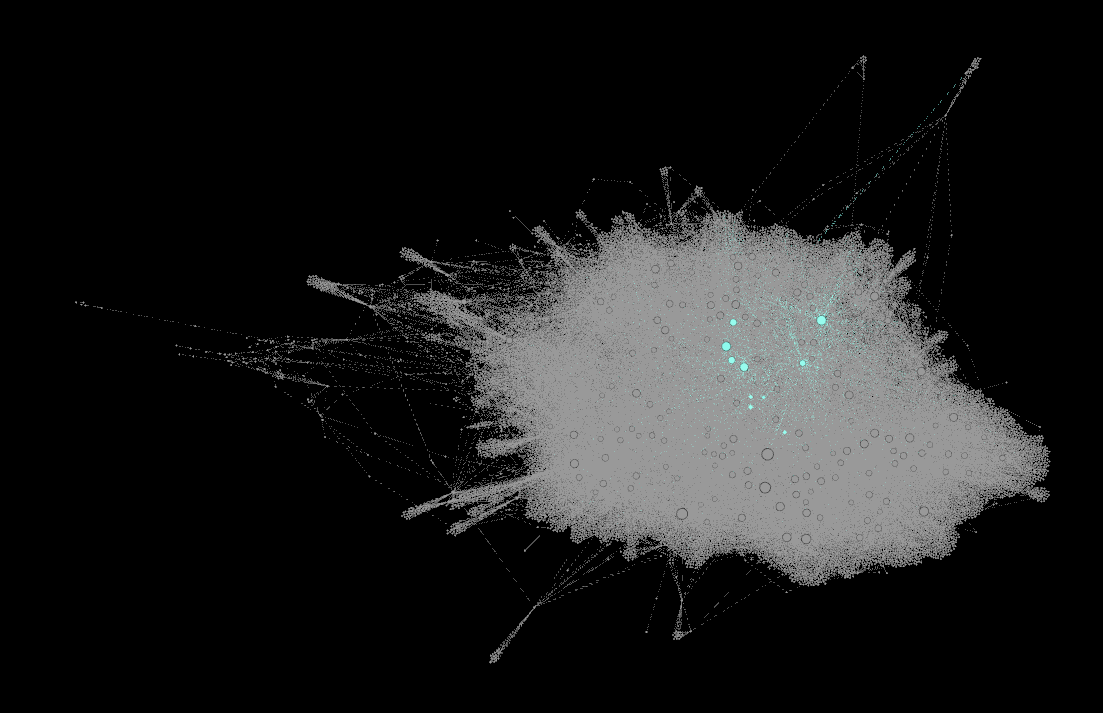

### betweenness centrality ###

In [11]:
nodes = nx.betweenness_centrality(kcore_g)

In [12]:
res = get_main_id(nodes, main_count = 10)
res

{'593203': 0.03390871539670601,
 '438016103': 0.01805348148581772,
 '190630566': 0.01611172964443261,
 '143787333': 0.01920443978171925,
 '227780200': 0.017958652638608442,
 '326947732': 0.019834378182047273,
 '136423061': 0.017285088820274103,
 '207313851': 0.02117482635259926,
 '143915344': 0.014881991642048707,
 '225749253': 0.030875488558036977}

Изобразим найденный точки на графе. Здесь точно также есть преподаватели и мтуденты. Примечательно, что из преполаватей остался Быков Дмитрий Александрович, который ведет историю России у всех классов (его действительно знает каждый).

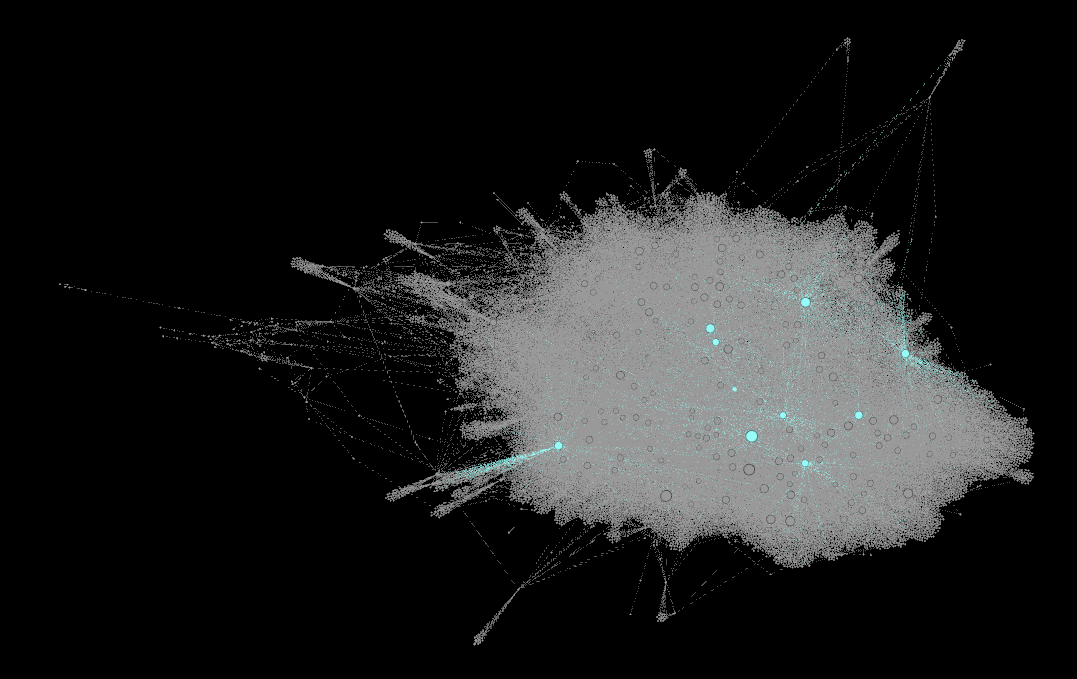

</br>

# Сообщества... в сообществе (2 балла) #

В этом задании надо примерить 2 алгоритма выявления сообществ и сравнить их результаты

Выберите алгоритм выделения сообществ на графах, например
* label propagation или 
* алгоритм на основе edge betweeness

и алгоритм на основе похожести вершин, например 
* расчитатайте попарную похожесть по jaccard, косинусному расстоянию или корреляцию
* при необходимости переведите "похожесть" в "расстояние" (чем больше значение тем "дальше" объекты друг от друга)
* подайте матрицу попарных расстояний в алгоритм кластеризации, например в DBSCAN

Для обоих вариантов
* Выделите сообщества, опираясь на максимальное значение модулярности для полученного разбиения
* Изобразите граф с вершинами, раскрашенными в цвет своего сообщества в gephi
* Попробуйте проинтерпретировать полученные сообщества, кто эти люди, почему они связаны?
* Какой метод на ваш взгляд сработал лучше?

In [271]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from random import seed
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

Для анализа будем использовать 10-core:

In [272]:
kcore = k_core(g, k = 5)
size = kcore.number_of_nodes()
print("Число узлов в графе:", size)

Число узлов в графе: 3365


In [273]:
num = {}
k = 0
for id_ in kcore.nodes():
    num[id_] = k
    k += 1

### Label propagation ###

In [313]:
def get_labeling_from_partition(partition):    
    all_nodes = set()
    for cluster in partition:
        all_nodes |= cluster
    num_nodes = len(all_nodes)
    labeling = np.ones((num_nodes,), dtype=int)

    for label, ids in enumerate(partition):
        ids = [num[list(ids)[k]] for k in range(len(ids))]
        #print(ids)
        labeling[ids] = label
        
    return labeling

In [316]:
seed(42)
lp_partition = nx.community.asyn_lpa_communities(kcore) # должен быть seed
lp_partition = list(lp_partition)

lp_labeling = get_labeling_from_partition(lp_partition)

In [317]:
len(set(lp_labeling))

5

In [318]:
#for id_ in num.keys():
#    g.nodes[id_]['class1'] = int(lp_labeling[num[id_]])
#nx.write_gml(g, 'graph_class.gml')

Получилось 5 групп. У меня не получилось изобразить их на том же графе, поэтому картинка немного отличается, также я убрала зависимость диаметра точки от степени вершины, чтобы не перегружать изображение:

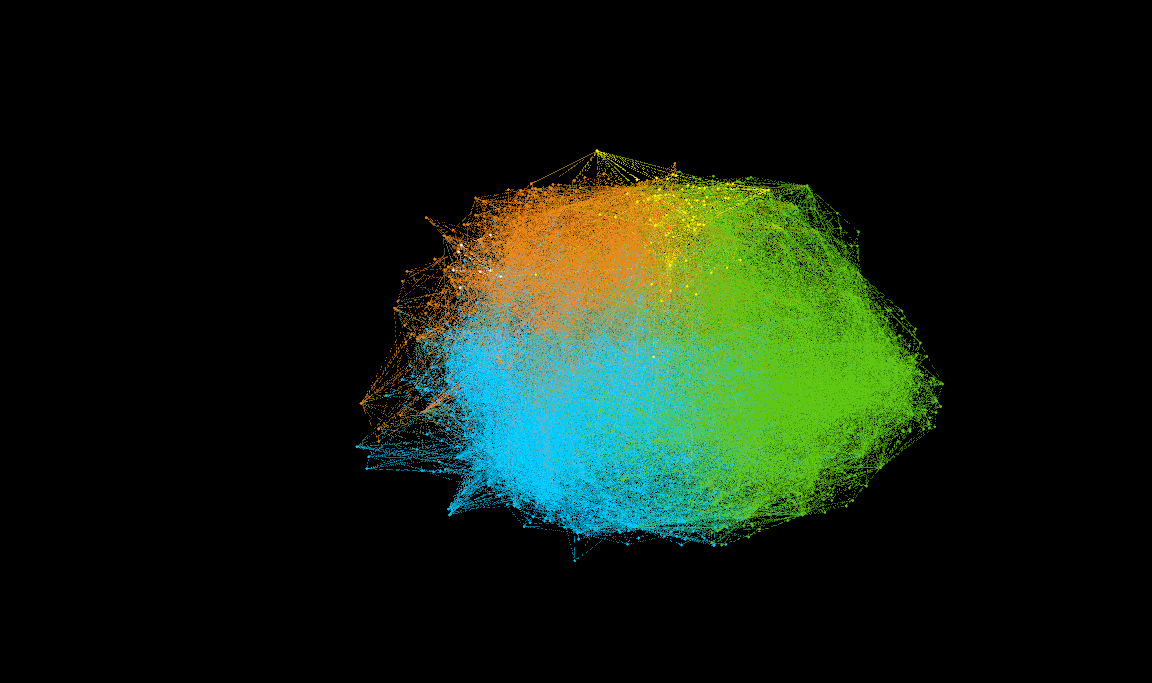

Класс, состоящий из белых вершин очень малочисленный, поэтому его трудно интерпритировать.

Посмотрим на вуз, который указан в профиле (отфильтруем точки, для которых этот параметр не указан или редкий):
В синей большинство точек оранжевого (2023 год) и желтого (2024 год) цвета.В зеленой группе большинство точек розового (2021 год), голубого (2022 год) и цвета морской волны (2020 год), но также встречаются желтые (2024 год)  и оранжевые (2023 год) точки.

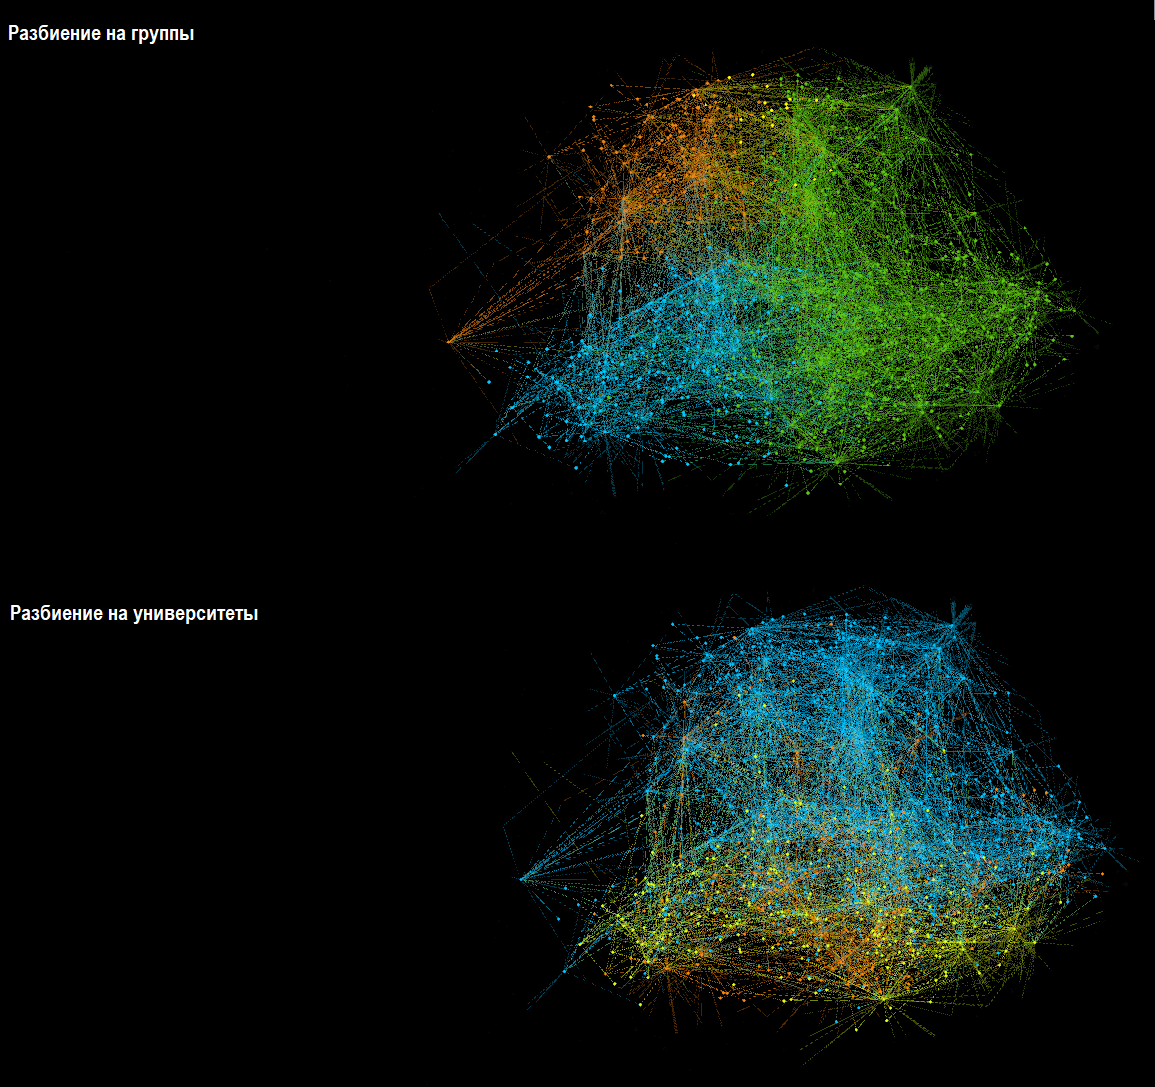

Посмотрим на год окончания вуза (отфильтруем точки, для которых этот параметр не указан или редкий): </br>
В синей большинство точек оранжевого (НИУ ВШЭ) и желтого (МФТИ) цвета.В зеленой группе большинство точек голубого (МГУ) цвета, но также встречаются желтые (МФТИ)  и оранжевые (НИУ ВШЭ) точки. В желтой группе преимущественно голубые точки (МГУ). В оранжевой группе также преимущественно голубые точки (МГУ), причем у многих пользователей отсутствует информация о вузе.

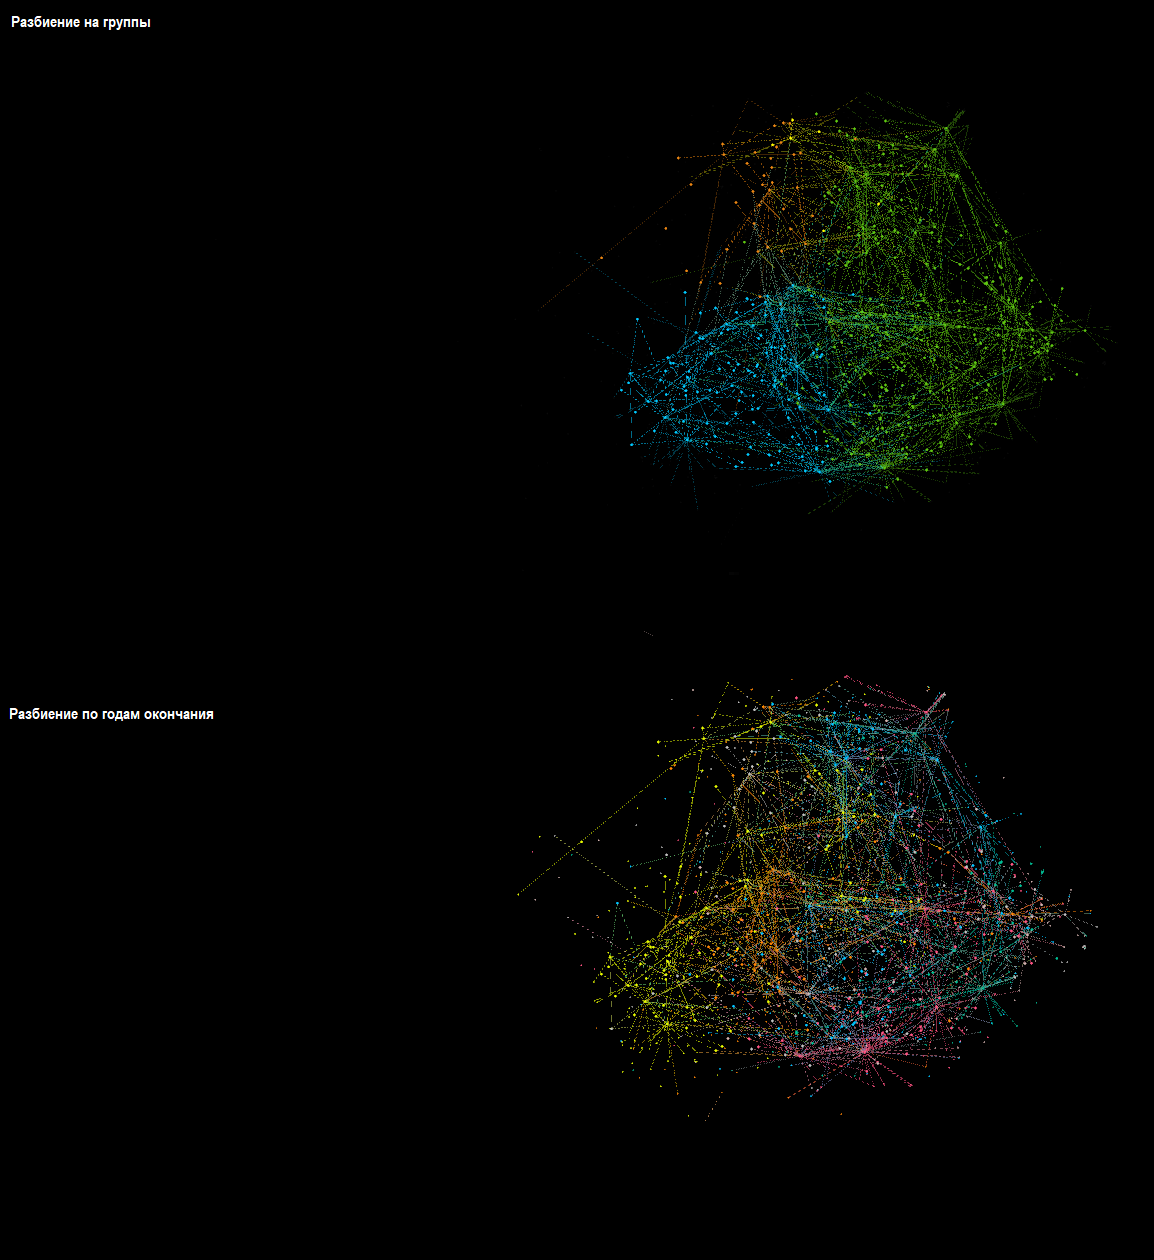

Посмотрим на факультеты (отфильтруем точки, для которых этот параметр не указан или редкий): </br>
Синяя группа соответствует студентам технических специальностей: факультет компьютерных наук (розовый цвет), факультет инноваций и высоких технологий (зеленый цвет), факультет общей и прикладной физики(желтый цвет), физический факультет (оранжевый цвет), механико-математический факультет (голубой цвет).</br>
Оранжевая группа соответствует студентам химбио направления: химический факультет (синий цвет), биологический факультет (цвет морской волны), факультет биоинженерии и информатики (ярко-зеленый цвет). </br>
Желтый кластер соответствует студентам-биологам. </br>
Зеленый кластер объединяет всех.

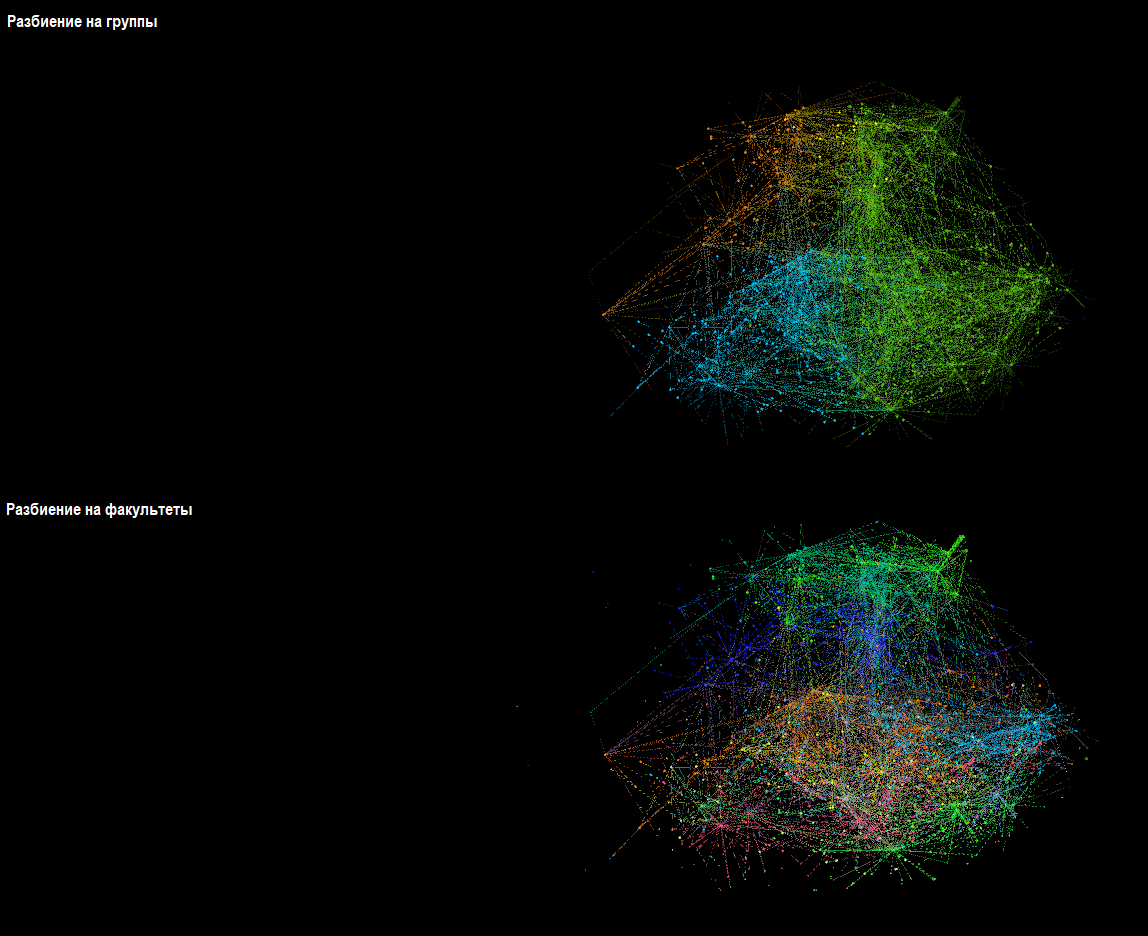

Итак, полученные группы можно проинтерпритировать следующим образом:
* Синяя группа - студенты технических направлений (в основном из МФТИ) 2023-2024 года выпуска.
* Желтая группа - студенты-биологи из МГУ
* Оранжевая группа - стденты химбио направления и школьки (возможно, именно эти студенты больше участвуют в общественной жизни СУНЦ-а после выпуска: устраивают гитарные вечера, приходят на концерты и выступают на них, ...)
* Зеленая группа - студенты 2020-2022 года выпуска. То есть мое поколение выпускников. Подслушка была популярна как раз в то время, когда мы учились, возможно поэтому мы все попали в одну группу.

### Алгоритм на основе похожести вершин ###

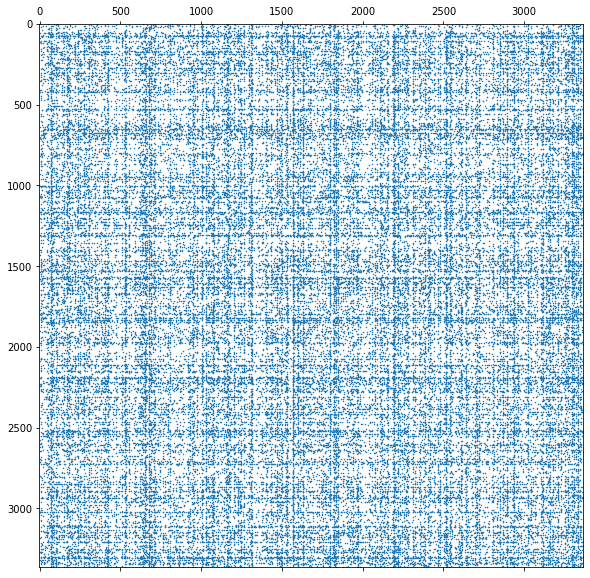

In [274]:
A = nx.adj_matrix(kcore)
fig = plt.figure(figsize = (10, 10))
plt.spy(A, markersize = 0.5)

In [304]:
jac = nx.jaccard_coefficient(kcore)
jac = np.array(list(jac))
jac.shape

(5626141, 3)

In [305]:
data = [float(jac[k,2]) for k in range(jac.shape[0])] 
row  = [num[  jac[k,0]] for k in range(jac.shape[0])] 
col  = [num[  jac[k,1]] for k in range(jac.shape[0])] 

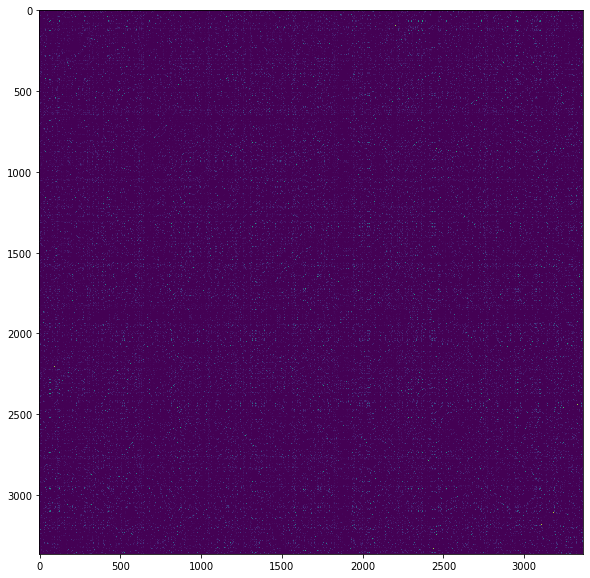

In [306]:
D = coo_matrix((data, (row, col)), shape=(size, size))
D = D + D.T

fig = plt.figure(figsize = (10, 10))
plt.imshow(D.toarray())

In [311]:
model = DBSCAN(metric = "precomputed", eps = 5e-3, min_samples = 200)
model.fit(D)
labels = model.labels_

In [312]:
label_count = {}
for label in labels:
    if label in label_count.keys():
        label_count[label] = label_count[label] + 1
    else:
        label_count[label] = 1
label_count

{-1: 186,
 1: 1704,
 8: 25,
 0: 625,
 3: 208,
 5: 172,
 7: 62,
 11: 27,
 2: 152,
 10: 7,
 9: 29,
 6: 67,
 12: 26,
 13: 23,
 4: 43,
 14: 9}

In [320]:
#for id_ in num.keys():
#    g.nodes[id_]['class2'] = int(labels[num[id_]])
#nx.write_gml(g, 'graph_class.gml')

Выделим 6 наиболее многочисленных групп. У меня не получилось изобразить их на том же графе, поэтому картинка немного отличается, также я убрала зависимость диаметра точки от степени вершины, чтобы не перегружать изображение:
Здесь даже визуально сложно различить группы. 

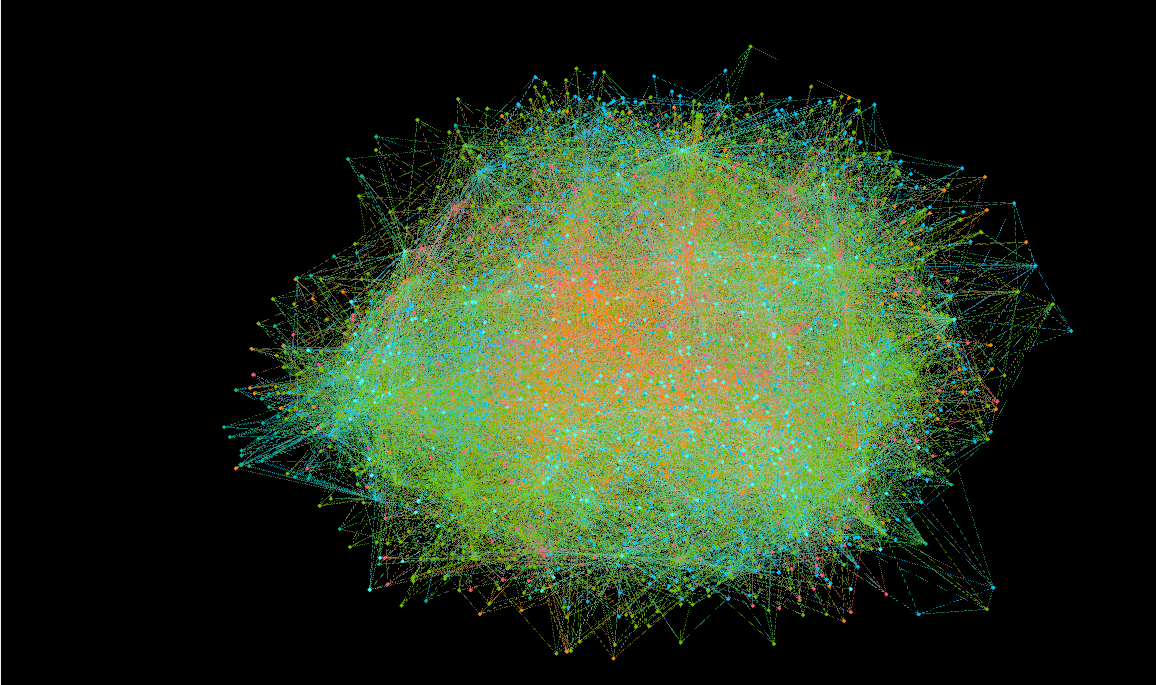

## В итоге ##
Label propagation разделил граф на 4 несложно интерпритируемые группы. А вот алгоритм, основанный на схожести вершин сработал, на мой взгляд, гораздо хуже: получившиеся группы сложно даже разделить, они перекрывают друг друга. 